In [7]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [27]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   # cho phép load ảnh lỗi 1 phần

class FaceDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(os.path.join(root_dir, csv_file))
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, OSError) as e:
            print(f"⚠️ Lỗi ảnh: {img_path}, bỏ qua.")
            return self.__getitem__((idx + 1) % len(self))  # lấy ảnh khác

        label = int(self.annotations.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label


In [28]:
transform = transforms.Compose([
    transforms.Resize((128,128)),   # resize ảnh
    transforms.ToTensor(),          # convert sang tensor
])

# dataset 1
dataset1 = FaceDataset(root_dir="photo", csv_file="list.csv", transform=transform)

# dataset 2
dataset2 = FaceDataset(root_dir="photo2", csv_file="list.csv", transform=transform)

# gộp 2 dataset
full_dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])

# ---- thử với 100 ảnh để test nhanh ----
subset_size = 1000
indices = list(range(subset_size))  # lấy 100 ảnh đầu tiên
small_dataset = Subset(full_dataset, indices)

# chia train / test
train_size = int(0.8 * len(small_dataset))
test_size = len(small_dataset) - train_size
train_dataset, test_dataset = random_split(small_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) #32
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 800, Test samples: 200


In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)   # 2 lớp: live / not_live

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3 #10
train_losses, train_accuracies = [], []
test_accuracies = []

best_acc = 0.0   # lưu test acc cao nhất

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # ---- Evaluate ----
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    # ---- Save Best Model ----
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved new best model with Test Acc: {best_acc:.2f}%")

⚠️ Lỗi ảnh: photo\live/00ff6296-b13e-11ed-b531-b42e9920aa06_face_image_live_003dca1e-b13e-11ed-8512-b42e9920aa05.jpg, bỏ qua.
⚠️ Lỗi ảnh: photo\live/7b15792e-b316-11ed-8f13-b42e9920aa06_face_image_live_7aaec3b4-b316-11ed-8fb8-b42e9920aa05.jpg, bỏ qua.
⚠️ Lỗi ảnh: photo\not_live/1890245e-b1fc-11ed-a57b-b42e9920aa06_face_image_live_183bcc7e-b1fc-11ed-8512-b42e9920aa05.jpg, bỏ qua.
⚠️ Lỗi ảnh: photo\live/1b4b23a8-b31c-11ed-8388-b42e9920aa06_face_image_live_1ad47e06-b31c-11ed-adcb-b42e9920aa05.jpg, bỏ qua.
Epoch [1/3] Loss: 0.3686, Train Acc: 87.75%, Test Acc: 90.50%
✅ Saved new best model with Test Acc: 90.50%
⚠️ Lỗi ảnh: photo\live/00ff6296-b13e-11ed-b531-b42e9920aa06_face_image_live_003dca1e-b13e-11ed-8512-b42e9920aa05.jpg, bỏ qua.
⚠️ Lỗi ảnh: photo\live/7b15792e-b316-11ed-8f13-b42e9920aa06_face_image_live_7aaec3b4-b316-11ed-8fb8-b42e9920aa05.jpg, bỏ qua.
⚠️ Lỗi ảnh: photo\not_live/1890245e-b1fc-11ed-a57b-b42e9920aa06_face_image_live_183bcc7e-b1fc-11ed-8512-b42e9920aa05.jpg, bỏ qua.
⚠️ 

In [30]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

⚠️ Lỗi ảnh: photo\not_live/1890245e-b1fc-11ed-a57b-b42e9920aa06_face_image_live_183bcc7e-b1fc-11ed-8512-b42e9920aa05.jpg, bỏ qua.
⚠️ Lỗi ảnh: photo\live/1b4b23a8-b31c-11ed-8388-b42e9920aa06_face_image_live_1ad47e06-b31c-11ed-adcb-b42e9920aa05.jpg, bỏ qua.
Test Accuracy: 89.50%


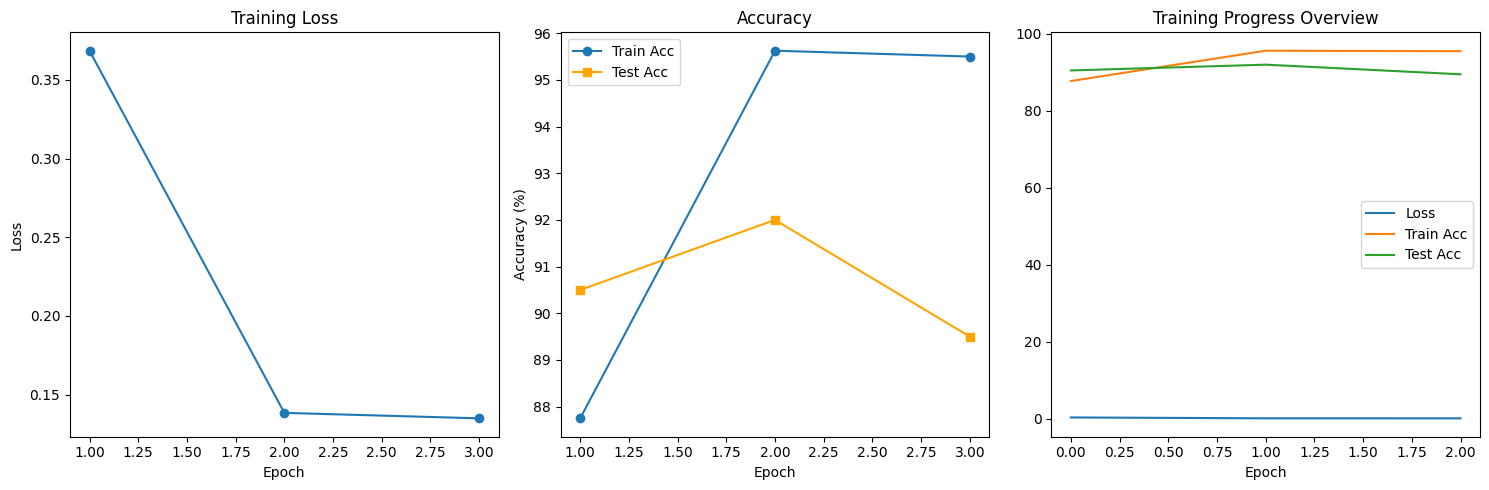

In [31]:
plt.figure(figsize=(15,5))

# Loss
plt.subplot(1,3,1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Train vs Test Accuracy
plt.subplot(1,3,2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label="Train Acc")
plt.plot(range(1, num_epochs+1), test_accuracies, marker='s', color="orange", label="Test Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Tổng quan
plt.subplot(1,3,3)
plt.plot(train_losses, label="Loss")
plt.plot(train_accuracies, label="Train Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.title("Training Progress Overview")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Load lại best model
best_model = SimpleCNN().to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()
print("Loaded best model with acc:", best_acc)

Loaded best model with acc: 92.0


In [33]:
from PIL import Image

# Ánh xạ label -> tên class
classes = ["not_live", "live"]

def predict_image(img_path, model, transform, device="cpu"):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # thêm batch dim

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return classes[predicted.item()]

Ảnh photo/not_live/spoof_2223_train0.jpg được dự đoán là: not_live


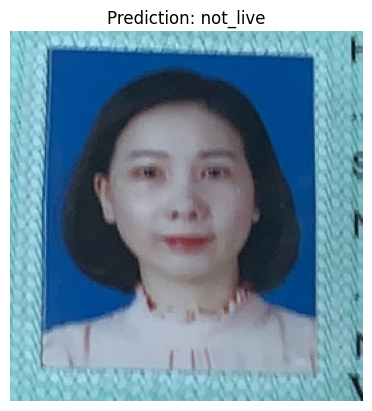

In [36]:
# Load lại best model
best_model = SimpleCNN().to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()

# Predict 1 ảnh bất kỳ
sample_img = "photo/not_live/spoof_2223_train0.jpg"   # đổi đường dẫn ảnh của bạn
result = predict_image(sample_img, best_model, transform, device)
print(f"Ảnh {sample_img} được dự đoán là: {result}")

import matplotlib.pyplot as plt

img = Image.open(sample_img).convert("RGB")
plt.imshow(img)
plt.title(f"Prediction: {result}")
plt.axis("off")
plt.show()